This is Brianna's working file for the svd

In [ ]:
TODO: 
- make the frontend better
- SVD for the lyrics 
- see if we can do SVD for the locations 

- locations pull data from travel advisor <-- make SVD + match it with the lyrics
- see if we can do emotion tags

This is to make SVD for the lyrics s

In [6]:
%pip install pandas numpy matplotlib scikit-learn scipy

  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 36.4 MB/s eta 0:00:00 0:00:01
Using cached numpy-2.2.4-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 39.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 32.6 MB/s eta 0:00:0000:0100:01
U

Created TF-IDF matrix with 5000 features


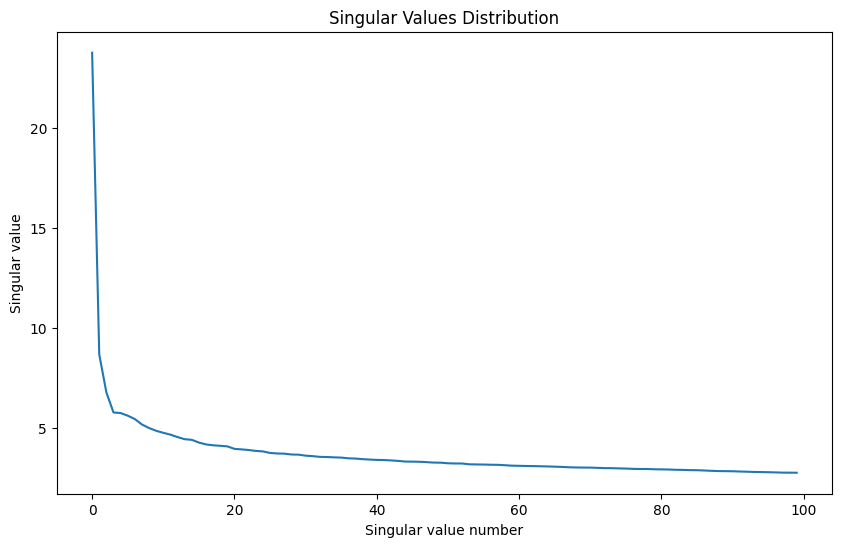

Dimension-reduced matrix shape: (5499, 100)
Computed embeddings for 5142 albums


{"i'm yours": [-0.001111087345443508,
  0.0036168333587523176,
  0.010269440820951839,
  0.005546273511961733,
  -0.02861961075552287,
  -0.0048129585799050675,
  0.015308737853959378,
  0.012386984890231439,
  -0.003037054515396037,
  -0.01884575289279517,
  -0.026488127315269373,
  -0.009106711912510584,
  0.012445924570150002,
  0.008791689819002121,
  -0.009927714009148686,
  -0.010099505819629631,
  0.003366965190358137,
  0.009244687633419972,
  0.004630326950957915,
  0.0014882104384169297,
  -0.022409867577260163,
  -0.021354309679104254,
  0.02028648447771322,
  0.016268752936002315,
  -0.008769404905220022,
  0.012413893675554264,
  0.013891598170600594,
  -0.013736259188566831,
  -0.0058242915161320925,
  -0.009871337356031702,
  -0.0008778944280519041,
  0.00224928650059429,
  0.00207567030993544,
  -0.03758995797701931,
  0.0006312523863340059,
  0.006030896733312115,
  -0.004074639177953321,
  -0.023530909945066632,
  0.004196720374741296,
  -0.008637855467738622,
  -0.01

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from collections import defaultdict
import json

def load_and_validate_data(filepath):
    """Load and validate the JSON data file."""
    try:
        # Try reading as JSON first
        lyric_df = pd.read_json(filepath)
        
        # Validate required columns exist
        if 'lyrics' not in lyric_df.columns:
            raise ValueError("JSON file must contain 'lyrics' column")
            
        print(f"Data loaded successfully. Found {len(lyric_df)} songs.")
        return lyric_df
        
    except ValueError as e:
        # If standard JSON reading fails, try alternative methods
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
                lyric_df = pd.DataFrame(data)
                return lyric_df
        except Exception as e:
            raise Exception(f"Could not parse JSON file: {str(e)}")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

def create_album_mapping(df):
    """Create song to song indexes mapping."""
    if 'song' not in df.columns:
        raise ValueError("DataFrame must contain 'song' column")
        
    albums_to_indexes = defaultdict(list)
    for idx, album in enumerate(df['song']):
        albums_to_indexes[album].append(idx)
    return albums_to_indexes

def main():
    # Configuration
    DATA_FILE = "datasets/shortened_spotify.json"
    SVD_COMPONENTS = 100
    SCALING_FACTOR = 0.25

    # 1. Load and validate data
    try:
        lyric_df = load_and_validate_data(DATA_FILE)
        albums_to_song_indexes = create_album_mapping(lyric_df)
    except Exception as e:
        print(f"Initialization failed: {e}")
        return

    # 2. Prepare lyrics matrix
    lyrics_matrix = lyric_df['text'].fillna('').tolist()  # Handle missing lyrics

    # 3. Create TF-IDF matrix
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
    td_matrix = vectorizer.fit_transform(lyrics_matrix)
    print(f"Created TF-IDF matrix with {td_matrix.shape[1]} features")

    # 4. Perform SVD
    u, s, v_trans = svds(td_matrix, k=SVD_COMPONENTS)
    v = v_trans.T

    # 5. Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(s[::-1])
    plt.xlabel("Singular value number")
    plt.ylabel("Singular value")
    plt.title("Singular Values Distribution")
    plt.show()

    # 6. Compute reduced dimension representations
    USr = u @ (np.diag(s) ** SCALING_FACTOR)
    print(f"Dimension-reduced matrix shape: {USr.shape}")

    # 7. Compute album embeddings
    album_embeddings = {}
    for album, indexes in albums_to_song_indexes.items():
        if indexes:  # Only process albums with songs
            album_embeddings[album] = USr[indexes].mean(axis=0).tolist()

    print(f"Computed embeddings for {len(album_embeddings)} albums")
    return album_embeddings

main()